<a href="https://colab.research.google.com/github/austinyu2019/practice_deeplearning/blob/master/%E2%80%9CGAN_keras_ipynb%E2%80%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 代码参考  
https://github.com/osh/KerasGAN

In [0]:
import random
import numpy as np
from keras.layers import Input
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconv2D, UpSampling2D
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.models import Model
from tqdm import tqdm
from IPython import display

Using TensorFlow backend.


## 读取数据集

In [0]:
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

print(np.min(X_train), np.max(X_train))
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

11493376/11490434 [==============================] - 1s 0us/step
0.0 1.0
X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


## 超参数设置

In [0]:
shp = X_train.shape[1:]
dropout_rate = 0.25

# Optim优化器
opt = Adam(lr=1e-4)
dopt = Adam(lr=1e-5)

## 定义生成器

In [0]:
from keras import backend as K
K.tensorflow_backend.set_image_dim_ordering('th')  # 用theano的图片输入顺序
# 生成1 * 28 * 28的图片
nch = 200
g_input = Input(shape=[100])
H = Dense(nch*14*14, kernel_initializer='glorot_normal')(g_input)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Reshape( [nch, 14, 14] )(H)  # 转成200 * 14 * 14
H = UpSampling2D(size=(2, 2))(H)
H = Convolution2D(100, (3, 3), padding="same", kernel_initializer='glorot_normal')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(50, (3, 3), padding="same", kernel_initializer='glorot_normal')(H)
H = BatchNormalization()(H)
H = Activation('relu')(H)
H = Convolution2D(1, (1, 1), padding="same", kernel_initializer='glorot_normal')(H)
g_V = Activation('sigmoid')(H)
generator = Model(g_input,g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_1 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 200, 14, 14)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 200, 28, 28)       0         
_________________

## 定义辨别器

In [0]:
# 辨别是否来自真实训练集
d_input = Input(shape=shp)
H = Convolution2D(256, (5, 5), activation="relu", strides=(2, 2), padding="same")(d_input)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Convolution2D(512, (5, 5), activation="relu", strides=(2, 2), padding="same")(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
H = Flatten()(H)
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(dropout_rate)(H)
d_V = Dense(2,activation='softmax')(H)
discriminator = Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 14, 14)       6656      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 14, 14)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 14, 14)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 512, 7, 7)         3277312   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512, 7, 7)         0         
_________

## 构造生成对抗网络

In [0]:
# 冷冻训练层
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
make_trainable(discriminator, False)

# 构造GAN
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 1, 28, 28)         4341425   
_________________________________________________________________
model_2 (Model)              (None, 2)                 9707266   
Total params: 14,048,691
Trainable params: 4,262,913
Non-trainable params: 9,785,778
_________________________________________________________________


##  训练

In [0]:
# 描绘损失收敛过程
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()
        
        
#  描绘生成器生成图像        
def plot_gen(n_ex=16,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [0]:
# 抽取训练集样本
ntrain = 10000
trainidx = random.sample(range(0,X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]  

# 预训练辨别器
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)  # 生成器产生样本
X = np.concatenate((XT, generated_images))  
n = XT.shape[0]
y = np.zeros([2*n,2])  # 构造辨别器标签 one-hot encode
y[:n,1] = 1
y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, epochs=1, batch_size=32)
y_hat = discriminator.predict(X)



Epoch 1/1
20000/20000 [==============================] - 28s 1ms/step - loss: 0.0468


In [0]:
#  计算辨别器的准确率
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_total = y.shape[0]
n_right = (diff==0).sum()

print( "(%d of %d) right"  % (n_right, n_total))

(20000 of 20000) right


In [0]:
# 存储生成器和辨别器的训练损失
losses = {"d":[], "g":[]}

In [0]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):
    for e in tqdm(range(nb_epoch)):  
        
        # 生成器生成样本
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # 训练辨别器
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        # 存储辨别器损失loss
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)  
    
        # 生成器生成样本
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        # 存储生成器损失loss
        make_trainable(discriminator,False)  # 辨别器的训练关掉
        g_loss = GAN.train_on_batch(noise_tr, y2)
        losses["g"].append(g_loss)
        
        # 更新损失loss图
        if e%plt_frq == plt_frq-1:
            plot_loss(losses)
            plot_gen()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

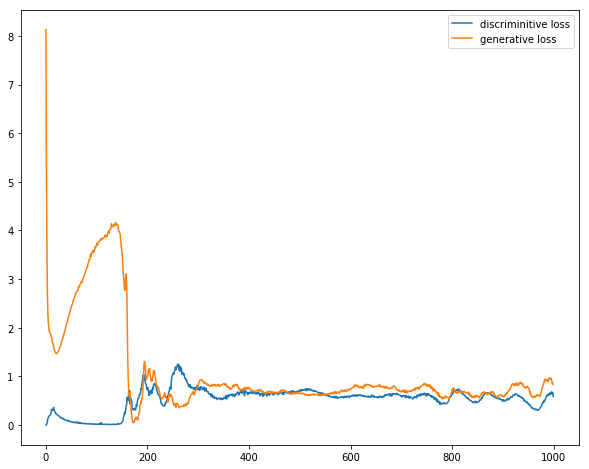

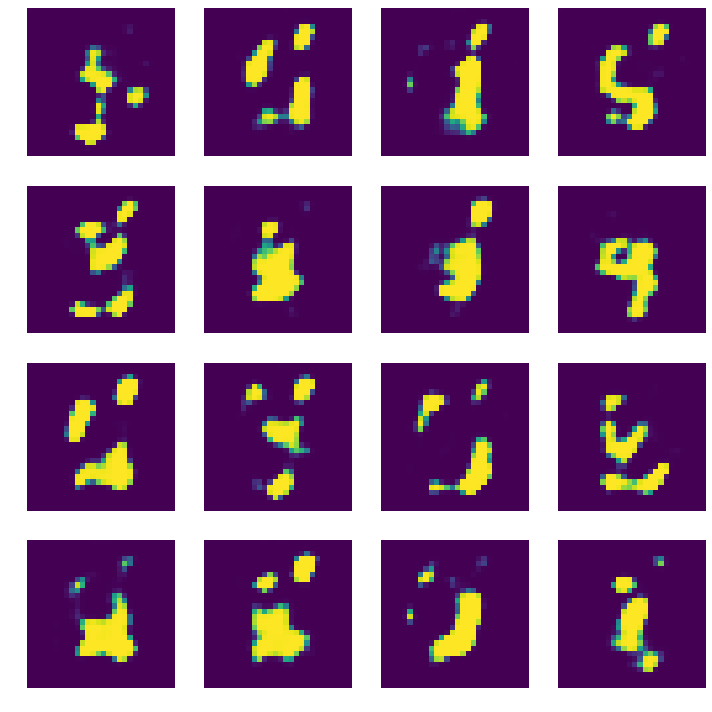

100%|██████████| 1000/1000 [09:58<00:00,  1.00it/s]


In [0]:
train_for_n(nb_epoch=1000, plt_frq=10,BATCH_SIZE=128)

## 调参技巧    
1.batch size  
2.adam优化器的learning rate  
3.迭代次数nb_epoch  
4.生成器generat和辨别器discriminator的网络结构  